# Advanced Lane finding - Project 4 of CarND Term1
This notebook implements the software pipeline to detect the road lanes for a self driving car using the advanced lane detection tools described in the module. The notebook depends on calibration and test data from the project repositery on github
https://github.com/udacity/CarND-Advanced-Lane-Lines

In [1]:
# Import all necessary packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib qt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import math

## Camera calibration
Calibrate the camera using the calibration images provided in the project repositery.

In [2]:
class CameraCalibrator:
    def __init__(self, path, chess_w, chess_h):
        """Initializes the Camera calibrator class.
        
        Calibrates the camera using the cv2 functions.

        Args:
            path: Path to the calibration chess board images.
            chess_w: Number of columns of chess board.
            chess_h: Number of rows of chess board.
        Returns:
            None.               
        """
        # Read calibration images
        imgfiles = glob.glob(path)

        # Initialize arrays to store object points and image points
        objpoints = [] # 3D points in real world
        imgpoints = [] # 2D points in image plane

        # Prepare object points, will be same for all images
        objp = np.zeros((chess_w*chess_h, 3), np.float32)
        objp[:, :2] = np.mgrid[0:chess_w, 0:chess_h].T.reshape(-1, 2)

        print('Calibrating the camera using images at '+path)
        # Loop through calibration images
        for imgfile in imgfiles:    
            img = mpimg.imread(imgfile)
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (chess_w, chess_h), None)
            if ret == True:
                # Append detected corners to imgpoints
                imgpoints.append(corners)        
                objpoints.append(objp)

        # Calibrate the camera using imgpoints and objpoints        
        ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        print('Calibration completed with ret: '+str(np.around(ret, 2)))
       
    def Undistort(self, image, show=False):
        """Undistorts an input image.
        
        Undistorts an input image using the camera matrix and distortion co-efficients calibrated during __init__

        Args:
            image: Input image.
            show: Optional argument to show the input and output images using imshow.
        Returns:
            Undistorted image.               
        """
        undist_image = cv2.undistort(image, self.mtx, self.dist, None, self.mtx)
        
        if (show == True):
            self.__ShowImages(image, undist_image, 'Image', 'Undistorted image')
            
        return undist_image
    
    def __ShowImages(self, im1, im2, title1, title2):
        """Show images.
        
        Show images using imshow

        Args:
            image: Input image.
            im1: Image 1
            im2: Image 2
            title1: Title for im1
            title2: Title for im2
        Returns:
            None
        """        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        f.tight_layout()
        ax1.set_title(title1)
        ax1.imshow(im1)
        ax2.set_title(title2)
        ax2.imshow(im2)

# Instantiate a camera calibrator class with path to calibration images and chess board dimensions        
calibrator = CameraCalibrator('./camera_cal/calibration*.jpg', 9, 6)

Calibrating the camera using images at ./camera_cal/calibration*.jpg
Calibration completed with ret: 1.19


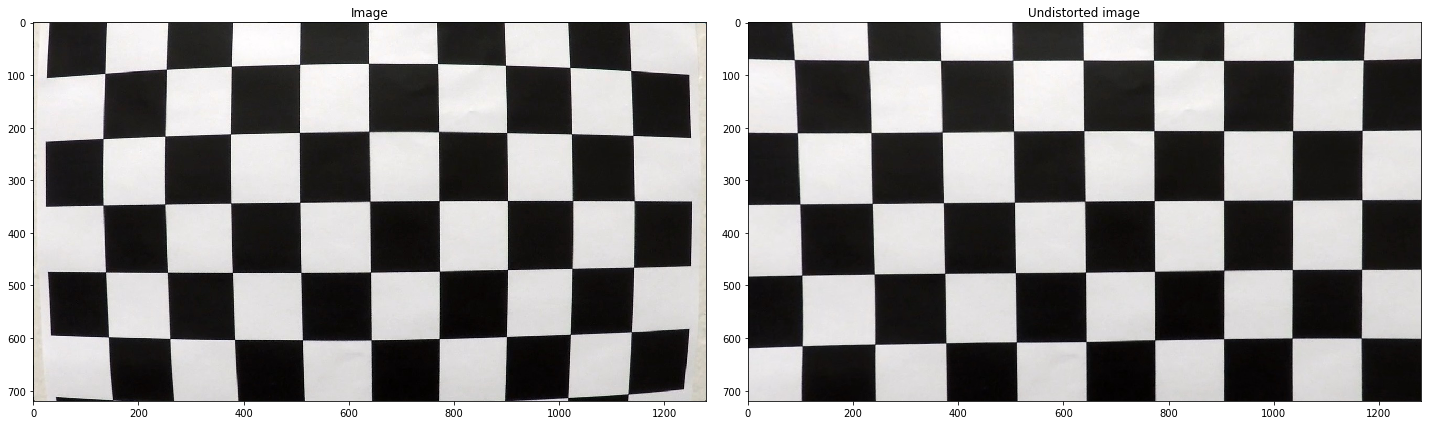

In [3]:
# Test camera calibrator
test_fname = 'camera_cal/calibration1.jpg'
dist_img = mpimg.imread(test_fname)
undist_img = calibrator.Undistort(dist_img, show=True)

## Gradient and Color threshold

In [4]:
class Thresholder:
    def apply_gradients(self, image, ksize=3, show=False):
        """Apply thresholds to gradient of the input image.
        
        Applies thresholds to graident of the input image.
            The function applies Gaussian blur as a pre-processing step to remove the noise.
            Applies the thresholds to,
                Sobel graident Along 'x' and 'y'
                Magnitude of the Sobel gradient
                Direction of the Sobe gradient
            
        Args:
            image: Input RGB image.
        Optiona Args:    
            ksize: Kernel size of sobel operator.
            show: show the input and output image.
        Returns:
            Output binary image.
        """
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Apply gaussian blur to remove noise
        blurred_gray = cv2.GaussianBlur(gray, (5,5), 0)        

        # Take the gradient in x and y separately
        sobelx = cv2.Sobel(blurred_gray, cv2.CV_64F, 1, 0, ksize=ksize)
        sobely = cv2.Sobel(blurred_gray, cv2.CV_64F, 0, 1, ksize=ksize)

        # Take the absolute value of the x and y gradients
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)

        # Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scaled_gradx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        scaled_grady = np.uint8(255*abs_sobely/np.max(abs_sobely))

        # Calculate direction of the gradient using np.arctan2(abs_sobely, abs_sobelx)
        dir_grad = np.arctan2(abs_sobely, abs_sobelx)
        
        # Calculate the magnitude of the gradient
        sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
        # Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scaled_grad_mag = np.uint8(255*sobelxy/np.max(sobelxy))

        # Filter scaled_gradx and scaled_grady using thresholds
        scaled_gradx_filt = cv2.inRange(scaled_gradx, 20, 100)
        scaled_grady_filt = cv2.inRange(scaled_grady, 20, 100)

        # Filter scaled_grad_mag and dir_grad using thresholds
        scaled_grad_mag_filt = cv2.inRange(scaled_grad_mag, 30, 100)
        dir_grad_filt = cv2.inRange(dir_grad, math.radians(40), math.radians(70))
        
        # Create binary output image
        grad_bin = np.zeros_like(scaled_gradx_filt)
        grad_bin[((scaled_gradx_filt != 0)    & (scaled_grady_filt != 0)) | 
                 ((scaled_grad_mag_filt != 0) & (dir_grad_filt != 0))] = 1
        
        if (show == True):
            self.__ShowImages(image, scaled_gradx_filt, 'Image', 'Gradient X')
            self.__ShowImages(image, scaled_grady_filt, 'Image', 'Gradient Y')
            self.__ShowImages(image, scaled_grad_mag_filt, 'Image', 'Gradient Magnitude')
            self.__ShowImages(image, dir_grad_filt, 'Image', 'Gradient Direction')
            self.__ShowImages(image, grad_bin, 'Image', 'Combined Gradient')

        # Return binary output
        return grad_bin 
    

    def apply_colors(self, image, show=False):
        """Apply thresholds to colors of the input image.
        
        Applies thresholds to colors of the input image 
            such that all colors except white and yellow are suppressed.
            Implementation is based on 
            https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html
          
        Args:
            image: Input RGB image.
        Optiona Args:    
            show: show the input and output image.
        Returns:
            Output binary image.
        """
        # Convert to HLS color space (better for extracting white)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

        # define range of white color in HLS
        lo_white = np.array([0,  200,0])
        up_white = np.array([255,255,255])
        
        # Threshold the HLS image to get white colored region
        mask_white = cv2.inRange(hls, lo_white, up_white)

        # Convert to HSV color space (better for extracting yellow)
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        # define range of yellow color in HSV
        lo_yel = np.array([20,100,100])
        up_yel = np.array([40,255,255])
        
        # Threshold the HSV image to get yellow colored region
        mask_yel = cv2.inRange(hsv, lo_yel, up_yel)     

        # Create binary output
        col_bin = np.zeros_like(mask_white)
        col_bin[((mask_yel != 0) | (mask_white != 0))] = 1
        
        if (show == True):
            self.__ShowImages(image, mask_yel, 'Image', 'Yellow')
            self.__ShowImages(image, mask_white, 'Image', 'White')
            self.__ShowImages(image, col_bin, 'Image', 'Yellow+White')

        # Return binary output
        return col_bin
    
    def apply_all(self, image, show=False):
        """Apply thresholds to gradients and colors of the input image.
        
        Applies thresholds to input image properties 
            like gradient and color such that pixels belonging to left and right lanes are highlighted.
          
        Args:
            image: Input RGB image.
        Optiona Args:    
            show: show the input and output image.
        Returns:
            Output binary image with bits set to 1 for pixels belonging to lanes.
        """        
        # Apply gradient thresholds
        grad_bin = self.apply_gradients(image, show=show)
        
        # Apply color thresholds
        col_bin = self.apply_colors(image, show=show)
                        
        # Combine the two binary thresholds
        com_bin = grad_bin | col_bin     

        if (show == True):
            self.__ShowImages(image, com_bin, 'Image', 'Thresholded Image')          
            
        return com_bin

    def __ShowImages(self, im1, im2, title1, title2):
        """Show images.
        
        Show images using imshow

        Args:
            image: Input image.
            im1: Image 1
            im2: Image 2
            title1: Title for im1
            title2: Title for im2
        Returns:
            None
        """        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        f.tight_layout()
        ax1.set_title(title1)
        ax1.imshow(im1)
        ax2.set_title(title2)
        ax2.imshow(im2, cmap='gray')

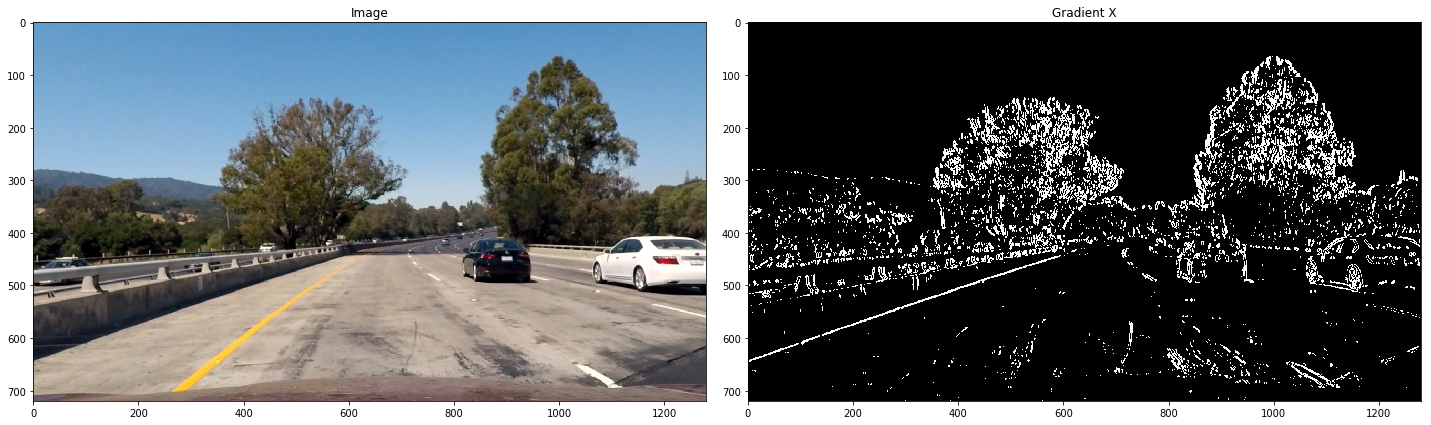

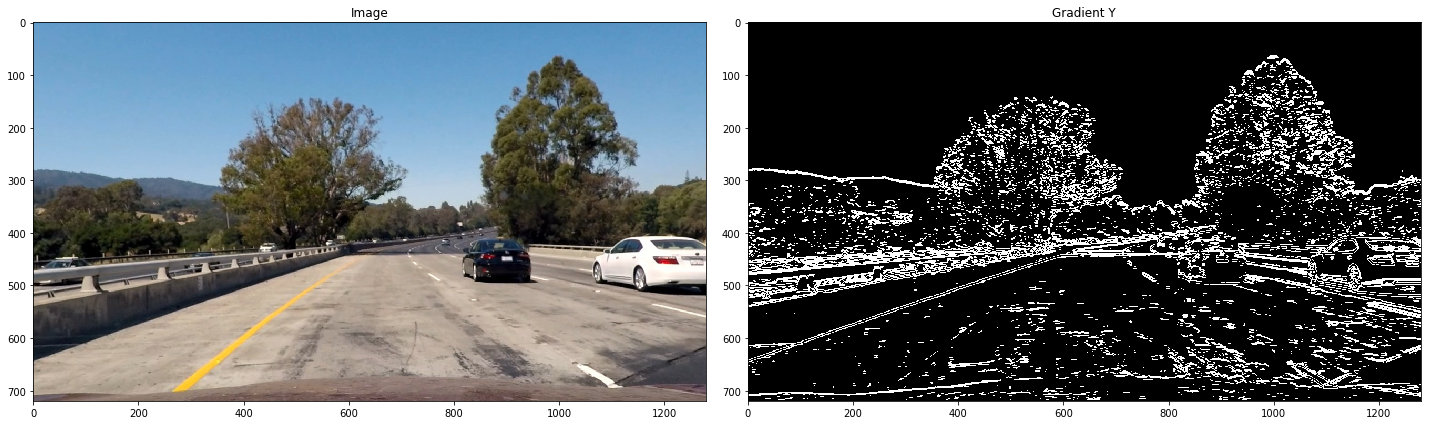

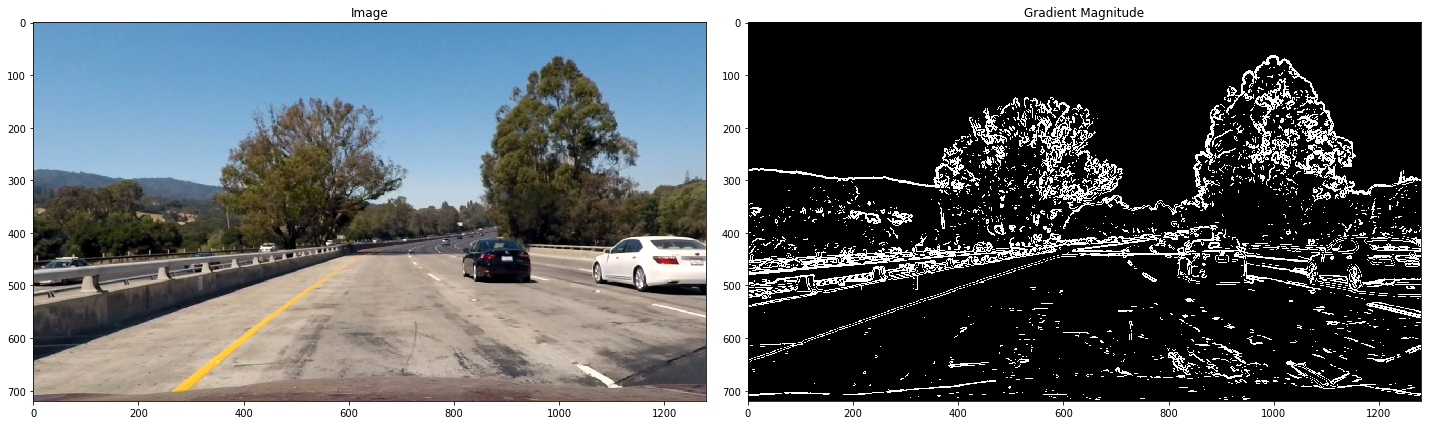

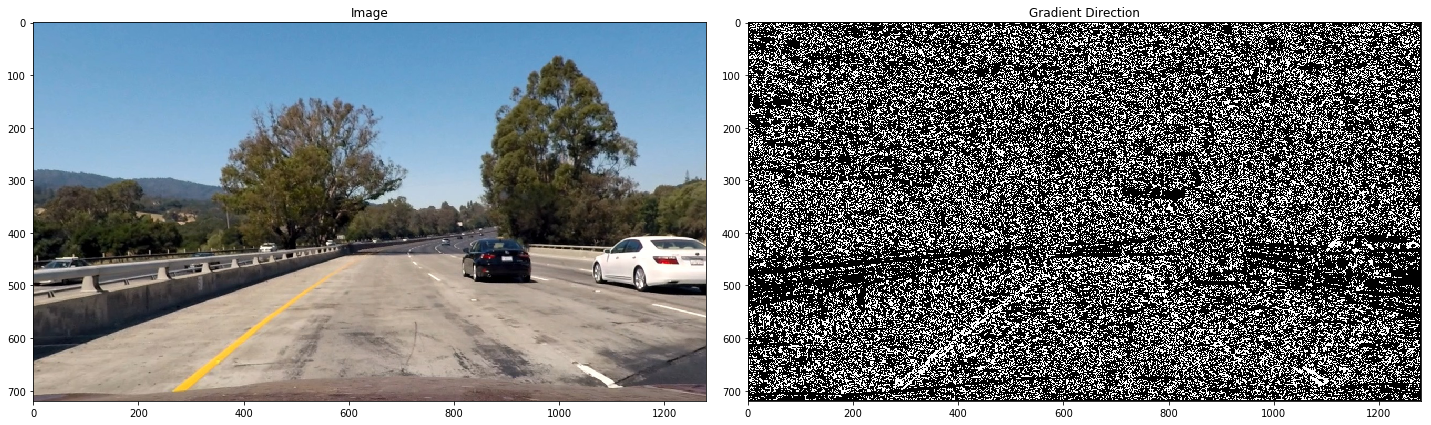

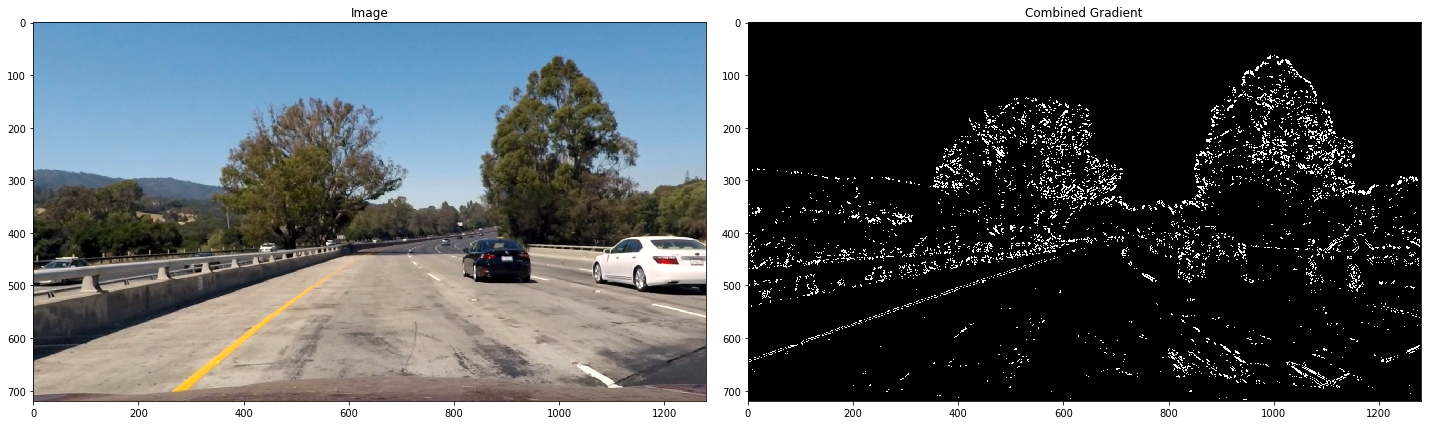

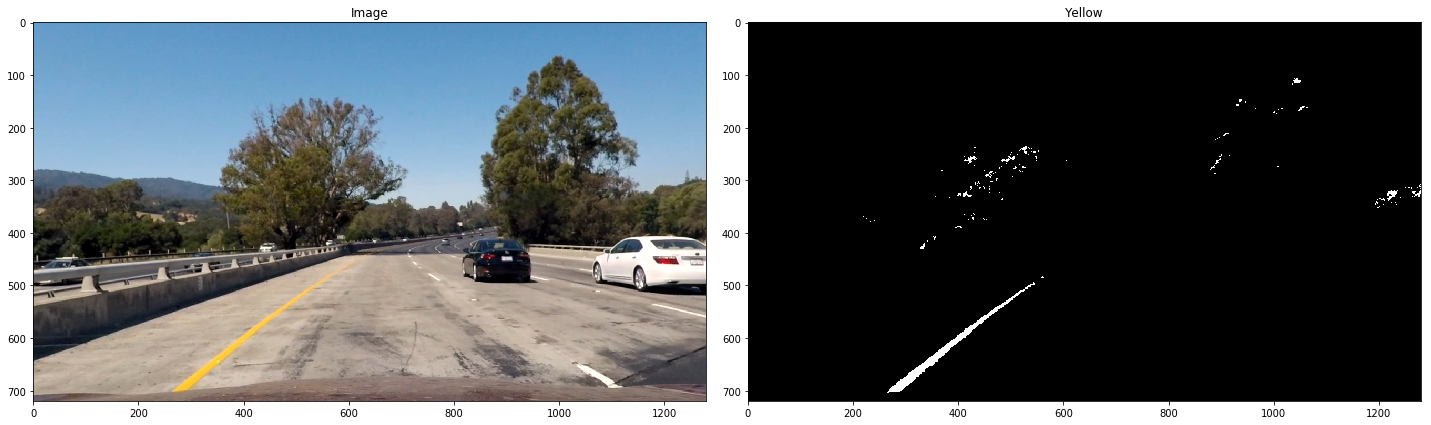

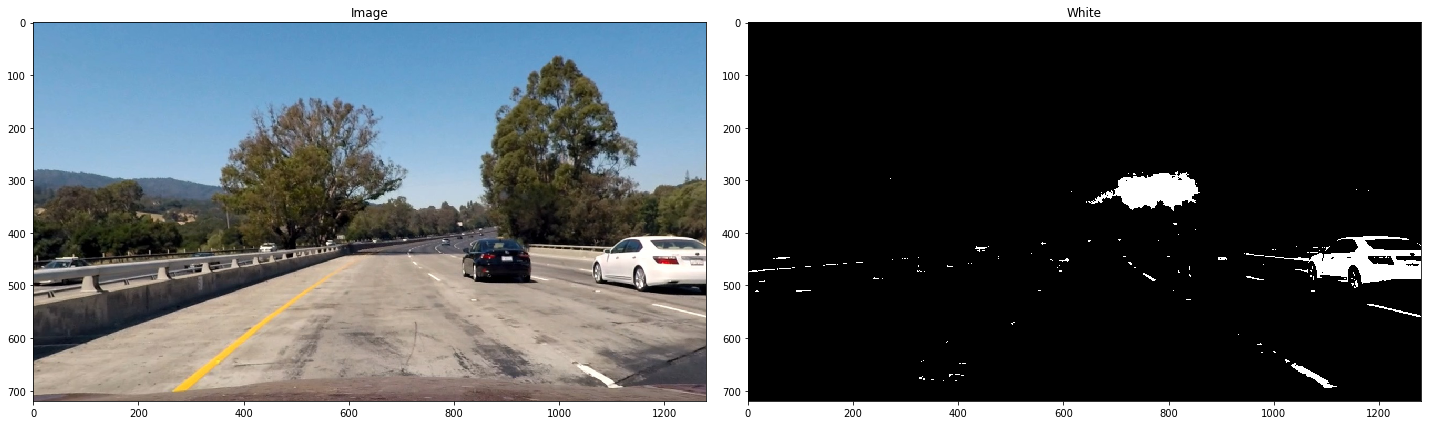

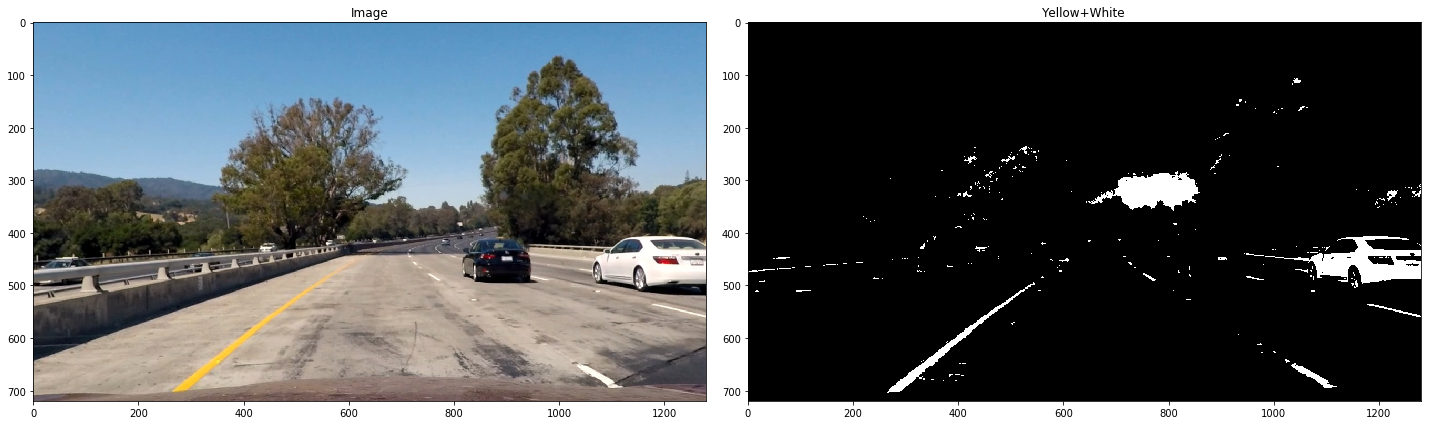

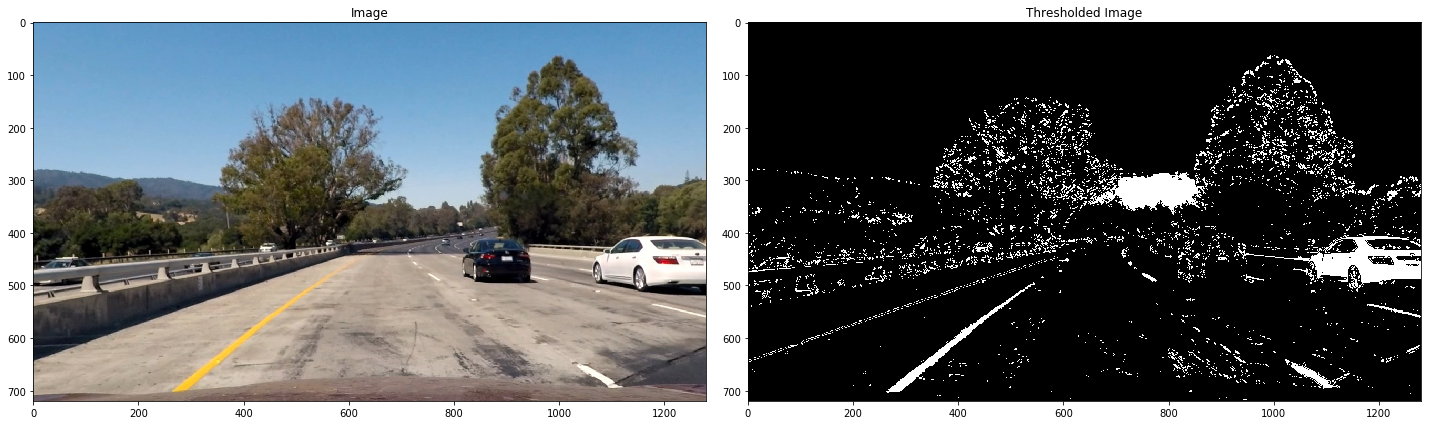

In [5]:
# Test thresholding
thresholder = Thresholder()
image = mpimg.imread('test_images/test1.jpg')
undist_image = calibrator.Undistort(image)
warped_image = thresholder.apply_all(undist_image, show=True)

## Perspective Transformation

In [6]:
class PerspectiveTransformer():
    def __init__(self):
        """Initializes the Perspective Transformer class.
        
        Computes the perspective transform matrix and inverse perspective transform matrix.
            These matrices are used by Warp() and Unwarp() methods.

        Args:
            None
        Returns:
            None.               
        """    
        # Points     [(left_bot ), (left top ), (right top), (right bot)]
        self.s_pts = [(230,  700), (595,  450), (685,  450), (1080, 700)]
        self.d_pts = [(300,  700), (300,    0), (1000,   0), (1000, 700)]
        src = np.float32(self.s_pts)
        dst = np.float32(self.d_pts)
        self.M = cv2.getPerspectiveTransform(src, dst)        
        self.Minv = cv2.getPerspectiveTransform(dst, src)
   
    def Warp(self, image, show=False):
        """Warps an input image using perspective transform matrix.

        Uses the perspective transform matrix (M) computed in __init__()

        Args:
            image: Input image.
        Optional Args:
            show: Show input and output image using imshow
        Returns:
            warped_image.               
        """
        img_size = (image.shape[1], image.shape[0])
        warped_image = cv2.warpPerspective(image, self.M, img_size, flags=cv2.INTER_LINEAR)
        
        if show == True:            
            self.__ShowImages(image.copy(), warped_image.copy(), 'Image', 'Warped Image', True)            
            
        return warped_image
    
    def Unwarp(self, warped_image, show=False):
        """Unwarps an input image using inverse perspective transform matrix.

        Uses the inverse perspective transform matrix (M) computed in __init__()

        Args:
            image: (Warped) Input image.
        Optional Args:
            show: Show input and output image using imshow
        Returns:
            Unwarped_image.               
        """        
        img_size = (warped_image.shape[1], warped_image.shape[0])
        image = cv2.warpPerspective(warped_image, self.Minv, img_size, flags=cv2.INTER_LINEAR)
        
        if show == True:            
            self.__ShowImages(warped_image.copy(), image.copy(), 'Image', 'Unwarped Image', False)
        
        return image
    
    def __ShowImages(self, src, dst, title1, title2, warping):
        """Show images.
        
        Show images using imshow

        Args:
            src: Source image
            dst: Destination image
            title1: Title for src
            title2: Title for dst
            warping: Flag indicating of calling function is Warp or Unwarp
        Returns:
            None
        """ 
        cmap = None
        color = [255, 0, 0]

        if (src.ndim == 2):
            cmap = 'gray'
            color = [1.0]
        
        thickness = 2
        
        if (warping == True):            
            s_pts = self.s_pts;
            d_pts = self.d_pts;
        else:
            s_pts = self.d_pts;
            d_pts = self.s_pts;
            
        cv2.line(src, s_pts[0], s_pts[1], color, thickness)        
        cv2.line(src, s_pts[1], s_pts[2], color, thickness)
        cv2.line(src, s_pts[2], s_pts[3], color, thickness)
        cv2.line(src, s_pts[3], s_pts[0], color, thickness)

        cv2.line(dst, d_pts[0], d_pts[1], color, thickness)
        cv2.line(dst, d_pts[1], d_pts[2], color, thickness)
        cv2.line(dst, d_pts[2], d_pts[3], color, thickness)
        cv2.line(dst, d_pts[3], d_pts[0], color, thickness)

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        f.tight_layout()
        ax1.set_title(title1)
        ax1.imshow(src, cmap=cmap)       
        ax2.set_title(title2)
        ax2.imshow(dst, cmap=cmap)        

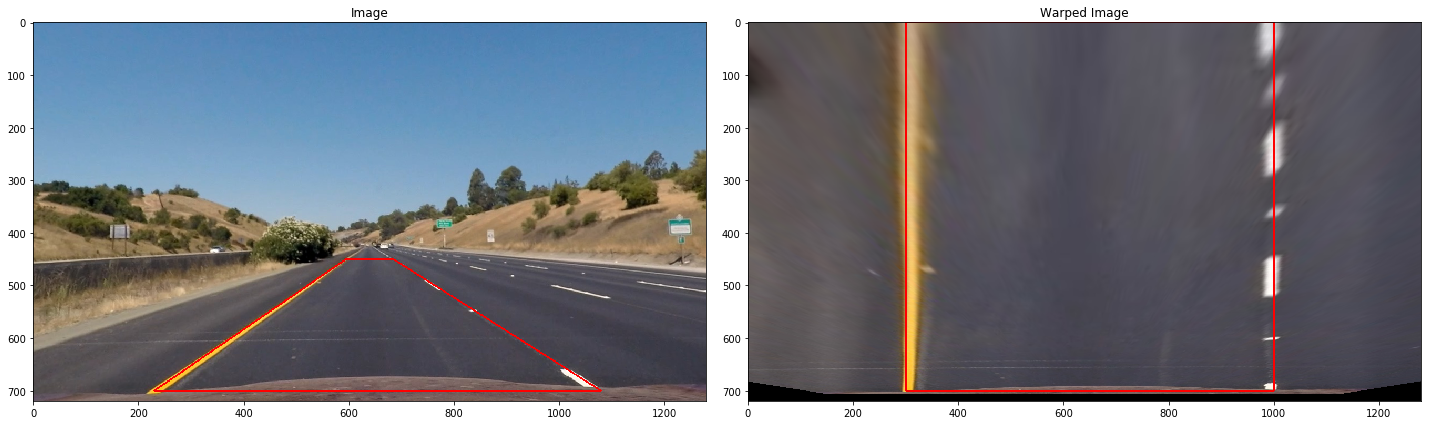

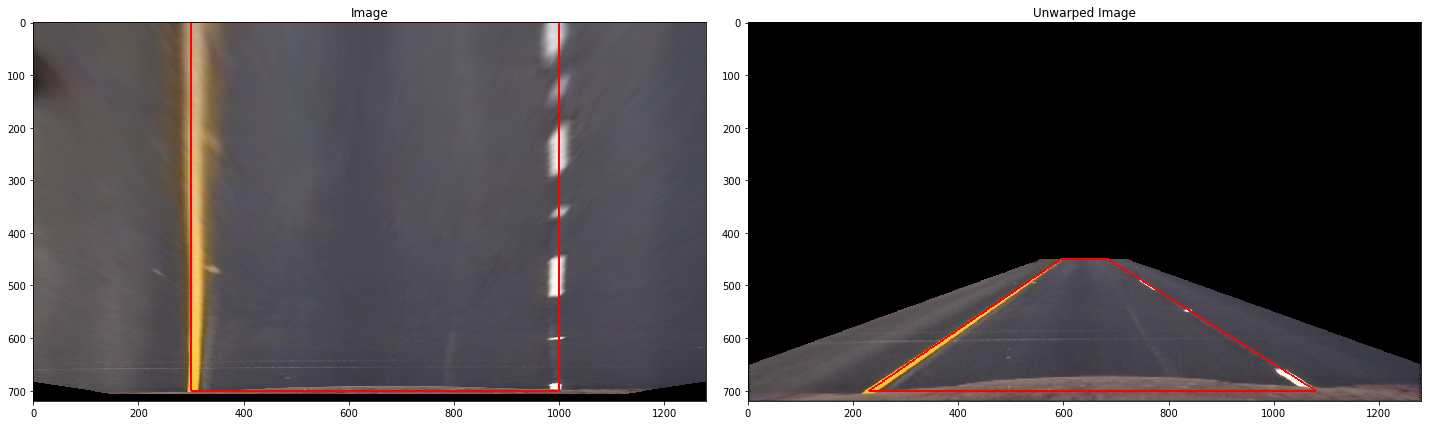

In [7]:
# Test (Thresholder ->) Transformer
image = mpimg.imread('test_images/straight_lines1.jpg')
undist_image = calibrator.Undistort(image)
thresholder = Thresholder()
thresholded_image = thresholder.apply_all(undist_image, show=False)
transformer = PerspectiveTransformer()
warped_image = transformer.Warp(undist_image, show=True)
unwarped_image = transformer.Unwarp(warped_image, show=True)

## Lane detection

In [8]:
# The below class represents a lane line (left or right).
class Line:
    # Reset
    def reset(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # radius of curvature of the line in meters
        self.roc = None 
        # distance in meters of vehicle center from the line
        self.offset = None 

    # Constructor
    def __init__(self):
        self.reset()    

In [9]:
# The below class represents a road lane.
class Lane:
    def reset(self):
        self.left_line.reset()
        self.right_line.reset()
        # Camera image height in pixels
        self.height = 720
        # Camera image width in pixels
        self.width = 1280
        # meters per pixel - X axis
        self.xm = 3.7/700 # The lane width in the warped image is about 700 pixels
        # meters per pixel - Y axis
        self.ym = 3.0/80 # The dashed line in the warped image seems to be about 80 pixels long

    def __init__(self):
        # left line of the lane
        self.left_line = Line()
        # right line of the lane
        self.right_line = Line()
        self.reset()
    
    # Function calculates the radius of curvature of lane lines in meters.
    def get_roc_in_meters(self, ploty, left_fitx, right_fitx):        
        # Calcuate ROC at the bottom of the image
        y_eval = np.max(ploty)  
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*self.ym, left_fitx*self.xm, 2)
        right_fit_cr = np.polyfit(ploty*self.ym, right_fitx*self.xm, 2)
        # Calculate the new radius of curvature for left and right lanes
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*self.ym + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        left_roc = np.int(left_curverad)
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*self.ym + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        right_roc = np.int(right_curverad)
        return left_roc, right_roc
    
    # Function does a sanity check on the lane lines to determine of they are valid.
    # The limits are set (quite liberally) based on trial and error.
    def sanity_check(self, left_fit, right_fit):
        ploty = np.linspace(0, self.height-1, self.height)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Get roc in meters
        left_roc, right_roc = self.get_roc_in_meters(ploty, left_fitx, right_fitx)

        # Compute the difference between x values
        diff_fit_x = right_fitx - left_fitx

        #print("ROC: left: ", left_roc, " right: ", right_roc)
        #print("Diff: max: ", np.max(diff_fit_x), " min: ", np.min(diff_fit_x))
        
        if (right_roc < 100):
            print('The right curvature is too low: '+str(right_roc)+'m')
            return False

        if (left_roc < 100):
            print('The left curvature is too low: '+str(left_roc)+'m')
            return False

        # Check if lanes are parallel
        if np.mean(diff_fit_x) < 500:
            print('Lines are too close'+np.mean(diff_fit_x))
            return False

        if np.mean(diff_fit_x) > 1000:
            print('Lines are too far'+np.mean(diff_fit_x))
            return False

        # Lines are probably fine
        return True        
    
    # The function does a full search of the warped image to classify 
    # the pixels based on windowing algorithm described in the lessons
    def locate_lines(self, warp_image, nwindows=9, margin=50, minpix=20):
        # Set the width of the windows +/- margin
        # Set minimum number of pixels found to recenter window

        # Calculate histogrm of bottom half of image along columns
        histogram = np.sum(warp_image[np.int(self.height/2):,:], axis=0)

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(self.width/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Set height of windows
        window_height = np.int(self.height/nwindows)
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = warp_image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries
            win_y_low = self.height - (window+1)*window_height #Top            
            win_y_high = self.height - window*window_height #Bottom          
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin 
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        return left_fit, right_fit

    # The function does a focussed search of the warped image to classify 
    # the pixels based on the last fitted polynomials
    def update_lines(self, warp_image, margin=50):
        # Get nonzero pixel positions in the image
        nonzero = warp_image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Get x positions for the nonzeroy with current fit
        # x = a*y^2 + b*y + c 
        left_fitx = self.left_line.current_fit[0]*(nonzeroy**2) + self.left_line.current_fit[1]*nonzeroy + self.left_line.current_fit[2]
        right_fitx = self.right_line.current_fit[0]*(nonzeroy**2) + self.right_line.current_fit[1]*nonzeroy + self.right_line.current_fit[2]

        # Find indices of all nonzero pixels within the margin around current fit    
        left_lane_inds = ((nonzerox > (left_fitx - margin)) & (nonzerox < (left_fitx + margin))) 
        right_lane_inds = ((nonzerox > (right_fitx - margin)) & (nonzerox < (right_fitx + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
        right_fit_new = np.polyfit(righty, rightx, 2)
        
        return left_fit_new, right_fit_new
    
    # The function does a full processing pipeline (undistort->threshold->warp) on the input image.
    # and then detects lane lines and unwarps and composites it on the original image.
    # Function returns the composite image as output.
    def process_frame(self, dist_image, show=False):
        # Undistort the image
        image = calibrator.Undistort(dist_image)
        # Apply gradient and color thresholds   
        thresholder = Thresholder()
        com_bin = thresholder.apply_all(image, show=show)
        # Apply perspective transformation
        transformer = PerspectiveTransformer()
        warped_image = transformer.Warp(com_bin, show=show)

        height = warped_image.shape[0]
        width = warped_image.shape[1]        
      
        left_fit = []
        right_fit = []

        if (self.left_line.detected == False) or (self.right_line.detected == False):
            # Eiether left or right lane is not available. Let's do a full search
            left_fit, right_fit = self.locate_lines(warped_image)
        else:
            # Lines are present, let's do an incremental search
            left_fit, right_fit = self.update_lines(warped_image)
    
            if (self.sanity_check(left_fit, right_fit) == False):
                # Lines seems to be invalid, let's do full search
                left_fit, right_fit = self.locate_lines(warped_image)        

        if (self.sanity_check(left_fit, right_fit) == False):
            self.left_line.detected = False
            self.right_line.detected = False
            print("Failed to locate lane lines. Ignoring this frame")
            return dist_image
       
        # Lane lines located.
        
        # Update class states
        self.left_line.detected = True
        self.right_line.detected = True
        self.left_line.current_fit = left_fit
        self.right_line.current_fit = right_fit    

        # Calculate x points for left and right lane for y points
        ploty = np.linspace(0, height-1, height)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        left_roc, right_roc = self.get_roc_in_meters(ploty, left_fitx, right_fitx)

        self.left_line.roc = left_roc
        self.right_line.roc = right_roc
        
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped_image).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Calculate offset
        self.left_line.offset = np.around((np.int(width/2) - left_fitx[height-1]) * self.xm, 2)
        self.right_line.offset = np.around((right_fitx[height-1] - np.int(width/2)) * self.xm, 2)
        # Calculate the offset of the vehicle and round it to 2 decimal places.
        # Vehicle is assumed to be at the center of the image.
        # So offset is the difference between center of the image and center of the detected lane.
        offset = np.around(((((right_fitx[height-1] + left_fitx[height-1])//2) - np.int(width/2)) * self.xm), 2)

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lanes to a warped blank image
        # Draw lane boundaries in RED
        cv2.polylines(color_warp, np.int_([pts_left]), 0, (255,0, 0),10)
        cv2.polylines(color_warp, np.int_([pts_right]), 0, (255,0, 0),10)
        # Fill lane in GREEN
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0), lineType=4)

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = transformer.Unwarp(color_warp) 
        # Add some information to the image
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(newwarp,'RoC (in m): L: '+str(left_roc)+' R: '+str(right_roc),
                            (10,100), font, 1,(255,255,0),3,cv2.LINE_AA)
        cv2.putText(newwarp,'Offset (in m) from Center: '+str(offset),
                            (10,200), font, 1,(255,255,0),3,cv2.LINE_AA)
        cv2.putText(newwarp,'Offset (in m) from lines: L: '+str(self.left_line.offset)+' R: '+str(self.right_line.offset),
                            (10,300), font, 1,(255,255,0),3,cv2.LINE_AA)
        
        # Combine the result with the original image
        result = cv2.addWeighted(image, 1, newwarp, 0.5, 0)
        return result

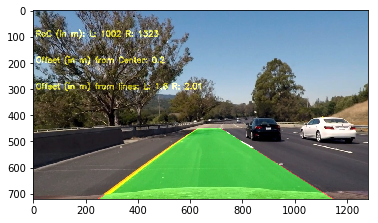

In [10]:
# Let's test with test images
lane = Lane()
lane.reset()
dist_image = mpimg.imread('test_images/test6.jpg')
out_image = lane.process_frame(dist_image)
plt.imshow(out_image)

In [11]:
# Let's try with videos
lane.reset()
clip1 = VideoFileClip("project_video.mp4")
processed_clip = clip1.fl_image(lane.process_frame)
output_video = 'marked_project_video.mp4'
%time processed_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video marked_project_video.mp4
[MoviePy] Writing video marked_project_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1260/1261 [06:31<00:00,  3.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: marked_project_video.mp4 

Wall time: 6min 33s
